##Single layer multiclass classification


In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST,EMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## MNIST DATASET

In [ ]:
train_data=MNIST(root='dataset/train',train=True,download=True,transform=ToTensor())
train_data

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.0MB/s]


Extracting dataset/train/MNIST/raw/train-images-idx3-ubyte.gz to dataset/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.29MB/s]

Extracting dataset/train/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/train/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]


Extracting dataset/train/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.58MB/s]

Extracting dataset/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/train/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/train
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data=MNIST(root='dataset/test',train=False,download=True,transform=ToTensor())
test_data

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.0MB/s]


Extracting dataset/test/MNIST/raw/train-images-idx3-ubyte.gz to dataset/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.56MB/s]

Extracting dataset/test/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/test/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.8MB/s]


Extracting dataset/test/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.34MB/s]

Extracting dataset/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/test/MNIST/raw



Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset/test
    Split: Test
    StandardTransform
Transform: ToTensor()

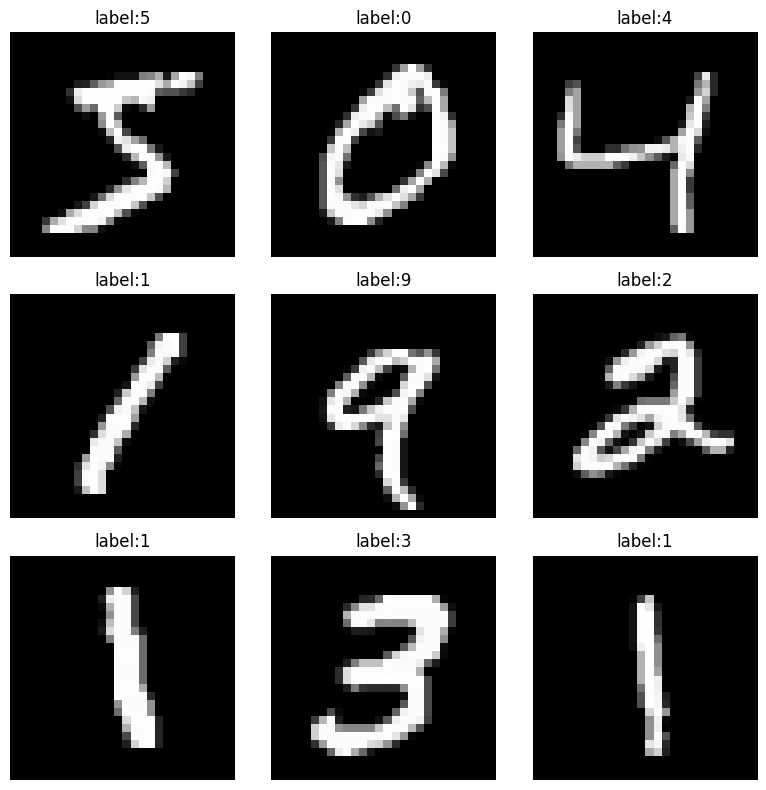

In [ ]:
#creating subplots
fig,ax=plt.subplots(3,3,figsize=(8,8))
for i in range(3):
  for j in range(3):
    img,label=train_data[i*3+j]
    ax[i,j].imshow(img.squeeze(),cmap='gray')
    ax[i,j].set_title(f'label:{label}')
    ax[i,j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#flattening training set
x_train=torch.flatten(train_data.data,1,2).to(torch.float32)
y_train=train_data.targets.reshape(x_train.shape[0],1).to(torch.int8)
x_train.shape,y_train.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [ ]:
#flattening test set
x_test=torch.flatten(test_data.data,1,2).to(torch.float32)
y_test=test_data.targets.reshape(x_test.shape[0],1).to(torch.int8)
x_test.shape,y_test.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

##One Hot Encoding for labels

In [ ]:
y_encod_train=torch.zeros((x_train.shape[0],len(train_data.classes))).to(torch.int8)
for i in range(x_train.shape[0]):
  y_encod_train[i][y_train[i].item()]=1

y_encod_train.shape

torch.Size([60000, 10])

In [ ]:
y_encod_test=torch.zeros((x_test.shape[0],len(test_data.classes))).to(torch.int8)
for i in range(x_test.shape[0]):
  y_encod_test[i][y_test[i].item()]=1

y_encod_test

tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8)

###Min Max scaling of training and testing data

In [ ]:
#scaling training data
for i in range(x_train.shape[0]):
  x_train[i]=(x_train[i]-x_train[i].min())/(x_train[i].max()-x_train[i].min())
#scaling test data
for i in range(x_test.shape[0]):
  x_test[i]=(x_test[i]-x_test[i].min())/(x_test[i].max()-x_test[i].min())

## Weights and Bias initialization

In [ ]:
#this one for testing manually computed gradient
w_test=torch.randn((x_train.shape[1],y_encod_train.shape[1]),dtype=torch.float32,requires_grad=True)
b_test=torch.randn((1,y_encod_train.shape[1]),dtype=torch.float32,requires_grad=True)

#kiaming weight initialization
w=torch.randn((x_train.shape[1],y_encod_train.shape[1]),dtype=torch.float32,requires_grad=False)*torch.sqrt(torch.tensor(2/x_train.shape[1]))
b=torch.randn((1,y_encod_train.shape[1]),dtype=torch.float32,requires_grad=False)*0.01
w.shape,b.shape

(torch.Size([784, 10]), torch.Size([1, 10]))

In [ ]:
z=x_train@w_test+b_test
print(z.max())

tensor(41.6259, grad_fn=<MaxBackward1>)


In [ ]:
def softmax(Z):
    return (torch.exp(Z)/torch.sum(torch.exp(Z),dim=1,keepdim=True))

def categorical_cross_entropy(y_encod_train,y_pred):
    return torch.sum(-y_encod_train*torch.log(y_pred),dim=1,keepdim=True).mean()

In [ ]:
y_pred=softmax(z)
loss=categorical_cross_entropy(y_encod_train,y_pred)
print('loss:',loss)

loss: tensor(18.8439, grad_fn=<MeanBackward0>)


In [ ]:
#??????
dl_da=((-y_encod_train/y_pred)/y_encod_train.shape[0]).unsqueeze(dim=2)
dl_da.shape

torch.Size([60000, 10, 1])

##Jacobian matrix

In [ ]:
def calc_jacob(x,y,a):
  jacob=torch.zeros((x.shape[0],y.shape[1],y.shape[1]),dtype=torch.float32)
  for i in range(x.shape[0]):
    for j in range(y.shape[1]):
      temp=a[i][j].item()
      jacob[i][j]=torch.where(a[i]==temp,temp*(1-temp),-temp*a[j])
  return jacob

def get_dl_dz(jacob,dl_da):
  return jacob@dl_da

In [ ]:
# #calculating gradients manually
# jacob=calc_jacob(x_train,y_encod_train,y_pred)
# #????
# dl_dz=get_dl_dz(jacob,dl_da)
# dz_dw= x_train

# dl_dw=dz_dw.T@dl_dz.squeeze(2)
# dl_db=torch.sum(dl_dz.squeeze(2),dim=0,keepdim=True)

# print(f"shape- dL_dZ: {dl_dz.shape}\
#        \nshape- dZ_dW: {dz_dw.shape}\
#       \nshape- dL_dW: {dl_dw.shape}\
#       \nshape- dL_db: {dl_db.shape}")

shape- dL_dZ: torch.Size([60000, 10, 1])       
shape- dZ_dW: torch.Size([60000, 784])      
shape- dL_dW: torch.Size([784, 10])      
shape- dL_db: torch.Size([1, 10])


##Testing if manually compute gradient are right

In [ ]:
loss_list_train=[]
loss_list_test=[]

In [ ]:
y_encod_train.shape[1]

10

##Training loop

In [ ]:
for i in range(500):
  z=x_train@w+b
  y_hat=softmax(z)
  loss=categorical_cross_entropy(y_encod_train,y_hat)

  loss_list_train.append(loss.item())
  dl_dz=(y_hat-y_encod_train)/x_train.shape[0]
  dz_dw=x_train
  dl_dw=dz_dw.T@dl_dz
  dl_db=torch.sum(dl_dz,dim=0,keepdim=True)
  w=w-0.99*dl_dw
  b=b-0.99*dl_db

  z_test=x_test@w+b
  y_hat_test=softmax(z_test)
  loss_test=torch.sum((-y_encod_test*torch.log(y_hat_test)),dim=1,keepdim=True)
  loss_list_test.append(loss_test.mean().item())


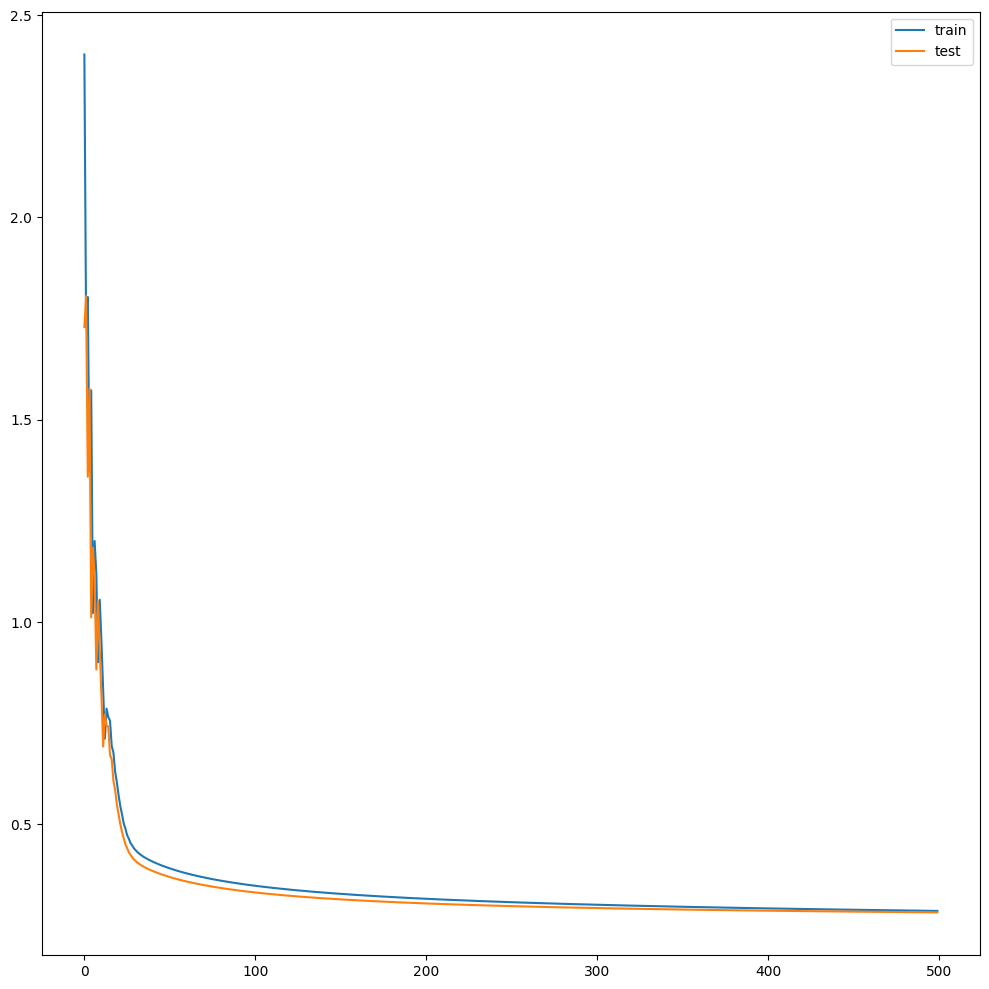

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(loss_list_train,label='train')
plt.plot(loss_list_test,label='test')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# train accuracy
y_pred=torch.argmax(y_hat,dim=1,keepdim=True)
train_acc=torch.sum(y_train==y_pred)/y_train.shape[0]


# test accuracy
z_test=x_test@w+b
y_hat_test=softmax(z_test)
y_pred_test=torch.argmax(y_hat_test,dim=1,keepdim=True)
test_acc=torch.sum(y_test==y_pred_test)/y_test.shape[0]

print(f"Train Accuracy: {train_acc}\
      \nTest Accuracy: {test_acc}")

Train Accuracy: 0.9209499955177307      
Test Accuracy: 0.9218000173568726


## Images we got wrong prediction on

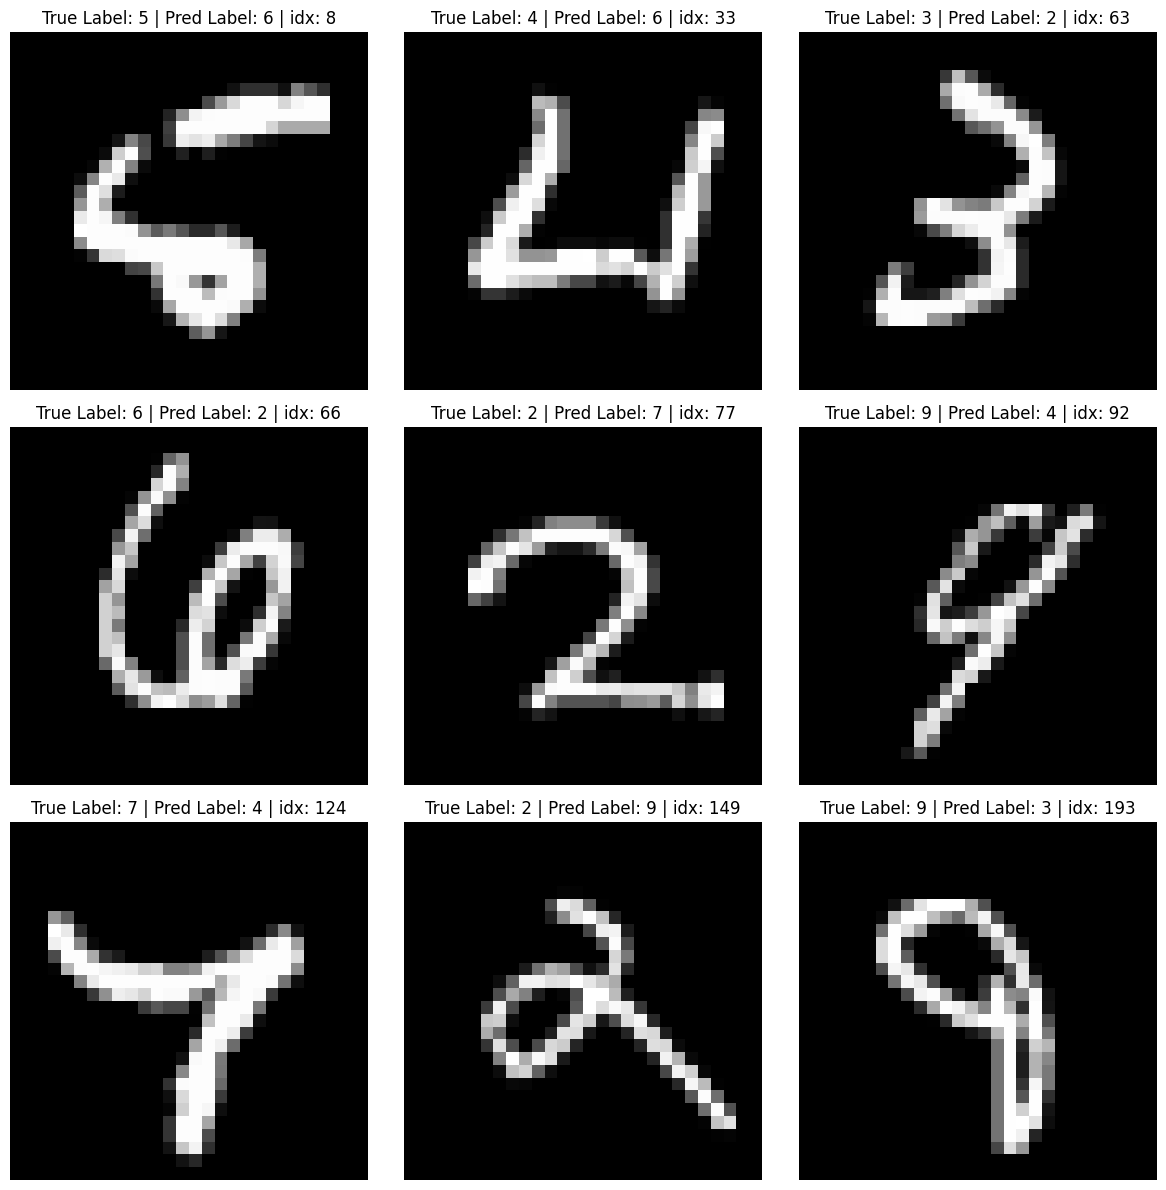

In [ ]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Plot images
c=-1
j=0
i=-1

end_loop=False
while i!=3:
    if end_loop:
        break
    i+=1
    j=0
    while j!=3:
        c+=1
        img, label = test_data[c]  # Accessing each image and label
        if label!=y_pred_test[c].item():
        # if label==8:
            axs[i, j].imshow(img.squeeze(),cmap='gray')
            axs[i, j].set_title(f'True Label: {label} | Pred Label: {y_pred_test[c].item()} | idx: {c}')
            axs[i, j].axis('off')  # Hide axis
            j+=1
        if((c==200) or (i==2 and j>2)):
            end_loop=True
            break

plt.tight_layout()
plt.show()
